# 混淆矩阵

通过测试集所有图像预测结果，生成多类别混淆矩阵，评估模型准确度。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置Matplotlib中文字体

In [1]:
# # windows操作系统
# plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [2]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [3]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体


--2022-08-18 16:32:39--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  17.8MB/s    in 0.5s    

2022-08-18 16:32:45 (17.8 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import math
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## 载入类别名称和ID

In [5]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# 获得类别名称
classes = list(idx_to_labels.values())
print(classes)

['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


## 载入测试集预测结果表格

In [6]:
df = pd.read_csv('测试集预测结果.csv')

In [7]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
0,fruit30_split/val/哈密瓜/106.jpg,0,哈密瓜,4.0,柚子,5.0,柠檬,7.0,梨,0.0,...,1.810175e-07,0.000001,0.000003,0.000010,0.000006,0.000111,1.294236e-04,3.994173e-07,0.000004,5.830796e-07
1,fruit30_split/val/哈密瓜/109.jpg,0,哈密瓜,6.0,桂圆,0.0,哈密瓜,8.0,椰子,1.0,...,8.460142e-08,0.000001,0.000001,0.001481,0.000045,0.000175,7.725556e-07,3.171619e-06,0.000033,2.559105e-06
2,fruit30_split/val/哈密瓜/114.jpg,0,哈密瓜,0.0,哈密瓜,26.0,西红柿,23.0,葡萄-白,1.0,...,9.829248e-03,0.007687,0.001150,0.040230,0.035187,0.001550,2.761092e-01,1.695518e-04,0.006084,1.219466e-03
3,fruit30_split/val/哈密瓜/116.jpg,0,哈密瓜,0.0,哈密瓜,16.0,芒果,4.0,柚子,1.0,...,4.417844e-05,0.000247,0.000071,0.001455,0.000003,0.000460,8.358340e-04,2.168997e-07,0.022086,4.123446e-04
4,fruit30_split/val/哈密瓜/118.png,0,哈密瓜,4.0,柚子,11.0,猕猴桃,23.0,葡萄-白,0.0,...,7.725807e-04,0.000075,0.000089,0.091698,0.000659,0.000463,3.796561e-03,3.087181e-08,0.000306,5.176165e-04


## 生成混淆矩阵

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
confusion_matrix_model = confusion_matrix(df['标注类别名称'], df['top-1-预测名称'])

In [10]:
confusion_matrix_model.shape

(30, 30)

In [11]:
confusion_matrix_model

array([[30,  0,  0,  0,  3,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  1],
       [ 0,  0, 29,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  1,  0,  0,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  1,  2,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 28,  2,  1,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
         0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 29,  

## 可视化混淆矩阵

In [22]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('混淆矩阵', fontsize=30)
    plt.xlabel('预测类别', fontsize=25, c='r')
    plt.ylabel('真实类别', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [23]:
# 查看所有配色方案
# dir(plt.cm)

In [24]:
# 子豪兄精选配色方案
# Blues
# BuGn
# Reds
# Greens
# Greys
# binary
# Oranges
# Purples
# BuPu
# GnBu
# OrRd
# RdPu

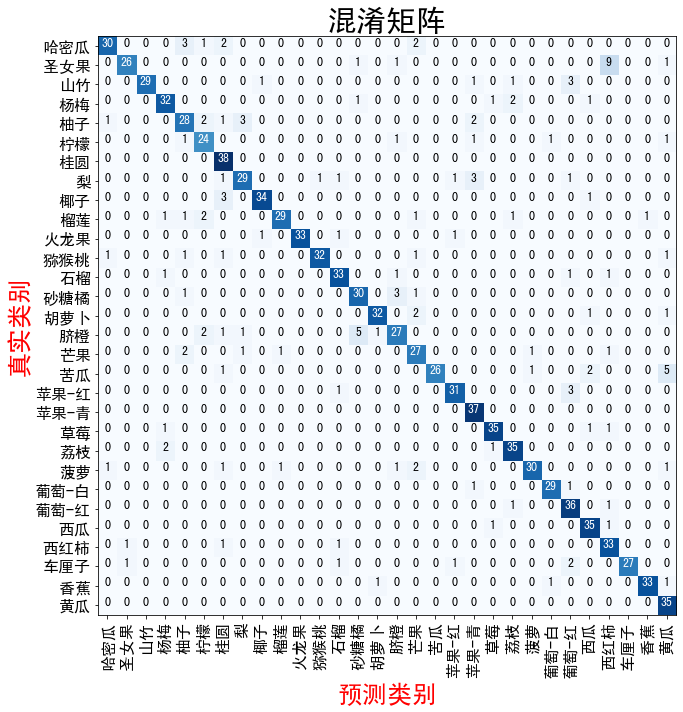

In [25]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

## 筛选出测试集中，真实为A类，但被误判为B类的图像

In [26]:
true_A = '荔枝'
pred_B = '杨梅'

In [27]:
wrong_df = df[(df['标注类别名称']==true_A)&(df['top-1-预测名称']==pred_B)]

In [28]:
wrong_df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
763,fruit30_split/val/荔枝/113.jpg,21,荔枝,3.0,杨梅,21.0,荔枝,24.0,葡萄-红,1.0,...,0.000809,0.176763,0.000001,0.000081,0.121157,0.000144,0.008242,0.002269,0.000062,1.642306e-05
796,fruit30_split/val/荔枝/91.jpeg,21,荔枝,3.0,杨梅,21.0,荔枝,20.0,草莓,1.0,...,0.037945,0.258566,0.000021,0.000068,0.003939,0.000234,0.002416,0.000018,0.000002,2.074321e-07


## 可视化上表中所有被误判的图像

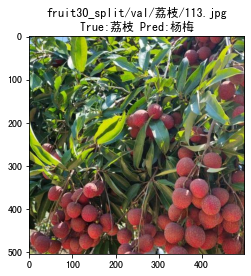

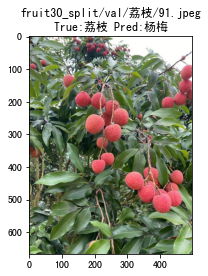

In [29]:
for idx, row in wrong_df.iterrows():
    img_path = row['图像路径']
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    title_str = img_path + '\nTrue:' + row['标注类别名称'] + ' Pred:' + row['top-1-预测名称']
    plt.title(title_str)
    plt.show()